In [1]:
%load_ext autoreload
%autoreload 

In [2]:
from typing import List, Tuple

import os
import os.path
import sys
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def predict_mask(signal, N, stride, model, thr_dice, ptg_voting = 0.25, batch_size = 16):
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)

    # Compute segmentation for all leads independently
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = models[fold].cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((signal.shape[0]), dtype=int)
    segmentation = np.zeros((3,signal.shape[0]))

    for i in range(0,windowed_mask.shape[0],12):
        counter[(i//12)*stride:(i//12)*stride+window_size] += 1
        segmentation[:,(i//12)*stride:(i//12)*stride+window_size] += windowed_mask[i:i+12].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

def get_ground_truth(basedir: str, database: str):
    if database == 'ludb':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ludb","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ludb","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ludb","T.csv"))
    elif database == 'zhejiang':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ZhejiangDB","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ZhejiangDB","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ZhejiangDB","T.csv"))
        
    # Divide into onsets/offsets
    Pon    = {k: P[k][0::2] for k in P}
    Poff   = {k: P[k][1::2] for k in P}
    QRSon  = {k: QRS[k][0::2] for k in QRS}
    QRSoff = {k: QRS[k][1::2] for k in QRS}
    Ton    = {k: T[k][0::2] for k in T}
    Toff   = {k: T[k][1::2] for k in T}

    # Generate validity
    validity = {
        k: [
            np.min(np.concatenate((P.get(k,[+np.inf]),QRS.get(k,[+np.inf]),T.get(k,[+np.inf])))),
            np.max(np.concatenate((P.get(k,[-np.inf]),QRS.get(k,[-np.inf]),T.get(k,[-np.inf])))),
        ] for k in QRS
    }
    return Pon,Poff,QRSon,QRSoff,Ton,Toff,validity
 
def get_file_list(basedir: str, database: str):
    if database == 'ludb':
        files = glob.glob(os.path.join(basedir,'ludb','*.dat'))
    elif database == 'zhejiang':
        files = glob.glob(os.path.join(basedir,'ZhejiangDB','RAW','*.csv'))
    return files
 
def get_sample(file: str, database: str) -> Tuple[float, np.ndarray]:
    if database == 'ludb':
        (signal, header) = wfdb.rdsamp(os.path.splitext(file)[0])
        fs = header['fs']
    elif database == 'zhejiang':
        signal = pd.read_csv(file).values
        fs = 1000.
    return signal, fs



# Inputs

In [7]:
with open('../list_files.txt') as f:
    list_files = f.read().splitlines()
    
i = 0
basedir=os.path.expanduser('~/DADES/DADES/Delineator/')
model_name=list_files[i]
database='zhejiang'
model_type='model_best'
batch_size=16
window_size=2048
hpc=False
use_morph=False
stride = 128

In [8]:
files = get_file_list(basedir, database)

for i,file in enumerate(tqdm.tqdm(files)):
    if i != 40:
        continue
    # Load singal
    (signal, fs) = get_sample(file, database.lower())
    fs = 2000
    root,fname = os.path.split(file)
    fname, ext = os.path.splitext(fname)

    # Downsample signal
    down_factor = int(fs/250.)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 75.0/250.,'low'),signal.T).T

    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(sak.signal.moving_lambda(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

    # Normalize and pad signal for inputing in algorithm
#     signal = np.pad(signal,((512,0),(0,0)),"edge")
    if signal.shape[0] < window_size:
        signal = np.pad(signal,((0,math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        signal = np.pad(signal,((0,math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)),(0,0)),mode='edge')

    # Correct amplitudes
    signal = signal/ampl

    # Obtain segmentation
    segmentation = 0
    for j,fold in enumerate(models):
        m = models[fold]
        segmentation += predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting)
            
    segmentation = segmentation >= 3

    klsghsahjgkjas



 12%|█▏        | 40/334 [00:00<00:00, 850.96it/s]


NameError: name 'models' is not defined

[None, None, None, None, None, None, None, None, None, None, None, None]

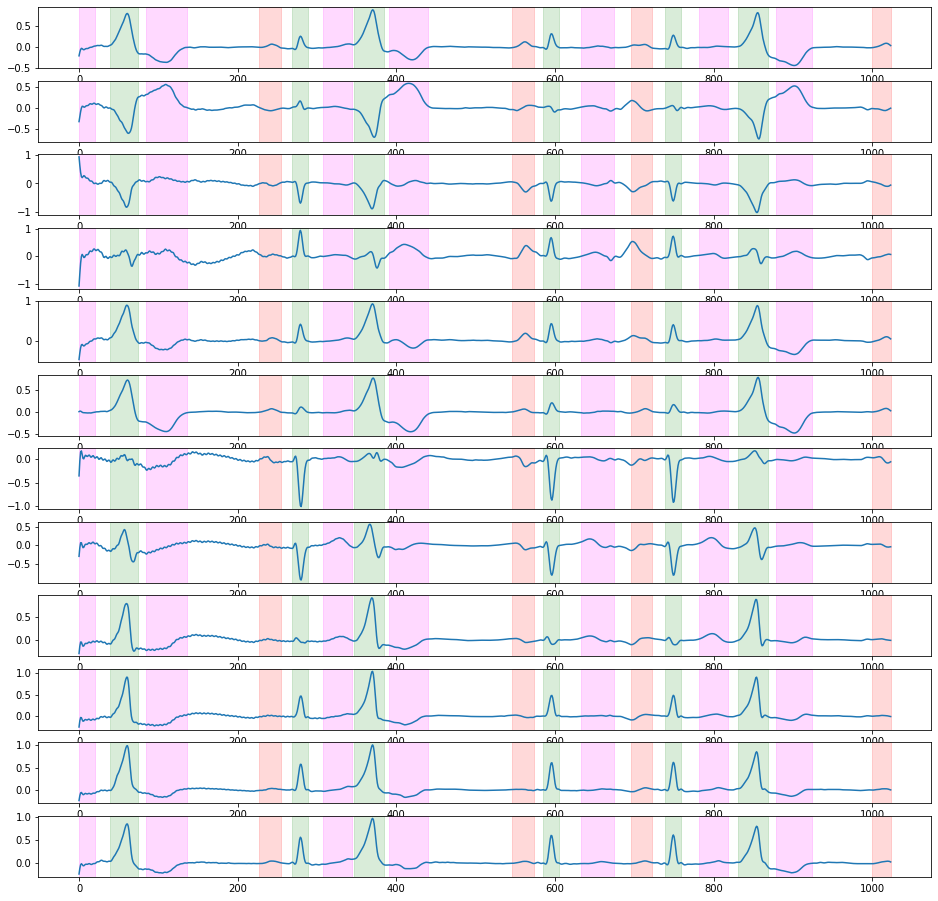

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

In [103]:
f,ax = plt.subplots(nrows=12,figsize=(16,16))

on = 0
off = 1024
off = off*2 if (fs == 1000) else off

[sak.visualization.signal.segmentation(signal[on:off,i],segmentation[:,on:off],ax=ax[i]) for i in range(12)]

In [50]:
def predict_mask(signal, N, stride, model, thr_dice, batch_size = 16, ptg_voting = 0.25):
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)

    # Compute segmentation for all leads independently
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = models[fold].cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((signal.shape[0]), dtype=int)
    segmentation = np.zeros((3,signal.shape[0]))

    for i in range(0,windowed_mask.shape[0],12):
        counter[(i//12)*stride:(i//12)*stride+window_size] += 1
        segmentation[:,(i//12)*stride:(i//12)*stride+window_size] += windowed_mask[i:i+12].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation


In [131]:
aaa = models[fold].cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice


In [132]:
aaa.shape

(8, 3, 2048)

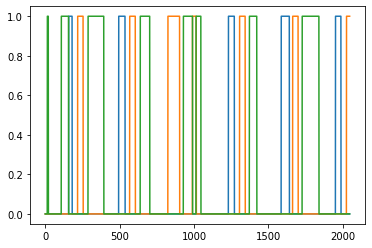

In [133]:
plt.plot(aaa[0].T)

In [ ]:
 > thr_dice

In [139]:
bbb = predict_mask(signal,2048,128,m,thr_dice,16,ptg_voting)

In [140]:
bbb.shape

(3, 2176)

[None, None, None, None, None, None, None, None, None, None, None, None]

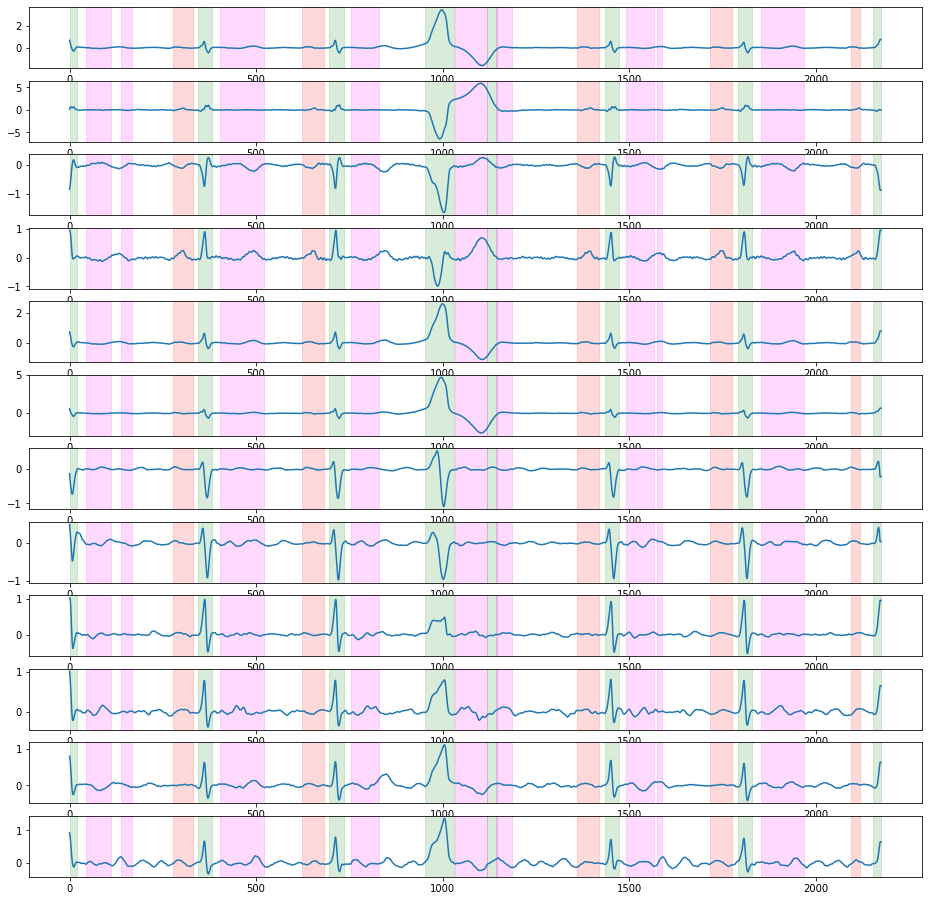

In [141]:
f,ax = plt.subplots(nrows=12,figsize=(16,16))
[sak.visualization.signal.segmentation(signal[:,i],segmentation,fig=f,ax=ax[i]) for i in range(12)]

# Check what's wrong in the script

In [61]:
from argparse import ArgumentParser
from typing import List, Tuple

import os
import os.path
import sys
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def predict_mask(signal, N, stride, model, thr_dice, ptg_voting = 0.25, batch_size = 16):
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(N,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)

    # Compute segmentation for all leads independently
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = model.cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((signal.shape[0]), dtype=int)
    segmentation = np.zeros((3,signal.shape[0]))

    for i in range(0,windowed_mask.shape[0],12):
        counter[(i//12)*stride:(i//12)*stride+N] += 1
        segmentation[:,(i//12)*stride:(i//12)*stride+N] += windowed_mask[i:i+12].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

def get_ground_truth(basedir: str, database: str):
    if database == 'ludb':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ludb","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ludb","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ludb","T.csv"))
    elif database == 'zhejiang':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ZhejiangDB","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ZhejiangDB","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ZhejiangDB","T.csv"))
        
    # Divide into onsets/offsets
    Pon    = {k: P[k][0::2] for k in P}
    Poff   = {k: P[k][1::2] for k in P}
    QRSon  = {k: QRS[k][0::2] for k in QRS}
    QRSoff = {k: QRS[k][1::2] for k in QRS}
    Ton    = {k: T[k][0::2] for k in T}
    Toff   = {k: T[k][1::2] for k in T}

    # Generate validity
    validity = {
        k: [
            np.min(np.concatenate((P.get(k,[+np.inf]),QRS.get(k,[+np.inf]),T.get(k,[+np.inf])))),
            np.max(np.concatenate((P.get(k,[-np.inf]),QRS.get(k,[-np.inf]),T.get(k,[-np.inf])))),
        ] for k in QRS
    }
    return Pon,Poff,QRSon,QRSoff,Ton,Toff,validity
 
def get_file_list(basedir: str, database: str):
    if database == 'ludb':
        files = glob.glob(os.path.join(basedir,'ludb','*.dat'))
    elif database == 'zhejiang':
        files = glob.glob(os.path.join(basedir,'ZhejiangDB','RAW','*.csv'))
    return files
 
def get_sample(file: str, database: str) -> Tuple[float, np.ndarray]:
    if database == 'ludb':
        (signal, header) = wfdb.rdsamp(os.path.splitext(file)[0])
        fs = header['fs']
    elif database == 'zhejiang':
        signal = pd.read_csv(file).values
        fs = 2000.
    return signal, fs



In [62]:
basedir='/home/guille/DADES/DADES/Delineator/'
model_name='WNet5BoundLoss_20201026000000'
database='zhejiang'
model_type='model_best'
batch_size=16
window_size=2048
hpc=False
use_morph=False


In [63]:
#########################################################################
# Load validation distribution
valid_folds = sak.load_data(os.path.join(basedir,'TrainedModels',model_name,'validation_files.csv'),dtype=None)
fold_of_file = {fname: k for k in valid_folds for fname in valid_folds[k]}

#########################################################################
# Load models
models = {}
for i in range(5):
    if os.path.isfile(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type))):
        models['fold_{}'.format(i+1)] = torch.load(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type)),pickle_module=dill).eval().float()
    else:
        print("File for fold {} not found. Continuing...".format(i+1))

#########################################################################
# Load ground truth
Pon, Poff, QRSon, QRSoff, Ton, Toff, validity = get_ground_truth(basedir, database)

#########################################################################
# Retrieve file list
files = get_file_list(basedir, database)

# Initialize output structures
PredictedPon = {}
PredictedPoff = {}
PredictedQRSon = {}
PredictedQRSoff = {}
PredictedTon = {}
PredictedToff = {}
predictions = {}

# Iterate over signals
window_size = 2**11
stride = 128
thr_dice = 0.8
ptg_voting = 0.5
target_fs = 250.
for i,file in enumerate(tqdm.tqdm(files)):
    # Load singal
    (signal, fs) = get_sample(file, database.lower())
    root,fname = os.path.split(file)
    fname, ext = os.path.splitext(fname)

    # Downsample signal
    down_factor = int(fs/250.)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 75.0/250.,  'low'),signal.T).T

    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(sak.signal.moving_lambda(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

    # Normalize and pad signal for inputing in algorithm
    if signal.shape[0] < window_size:
        signal = np.pad(signal,((0,math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        signal = np.pad(signal,((0,math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)),(0,0)),mode='edge')

    # Correct amplitudes
    signal = signal/ampl

    # Obtain segmentation
    for j,fold in enumerate(models):
        m = models[fold]
        if j == 0:
            segmentation = predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size).astype(int)
        else:
            segmentation += predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size)

    segmentation = segmentation >= 3

    # Morphological operations
    if use_morph:
        p               = cv2.morphologyEx(segmentation[0,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        qrs             = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        t               = cv2.morphologyEx(segmentation[2,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        segmentation[0,:] = cv2.morphologyEx(p,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        segmentation[1,:] = cv2.morphologyEx(qrs, cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        segmentation[2,:] = cv2.morphologyEx(t,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)

    # Obtain onsets/offsets
    pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
    qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
    ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])

    # Save stuff
    PredictedPon[fname] = (np.array(pon)*down_factor).tolist()
    PredictedPoff[fname] = (np.array(poff)*down_factor).tolist()
    PredictedQRSon[fname] = (np.array(qrson)*down_factor).tolist()
    PredictedQRSoff[fname] = (np.array(qrsoff)*down_factor).tolist()
    PredictedTon[fname] = (np.array(ton)*down_factor).tolist()
    PredictedToff[fname] = (np.array(toff)*down_factor).tolist()

    # Retrieve mask as 1D
    predictions[fname] = segmentation
    
    adskgljhjaglj


#########################################################################
# Retrieve onsets and offsets
pon, poff, qrson, qrsoff, ton, toff = {},{},{},{},{},{}

for k in predictions:
    if f"{k}###I" not in validity:
        continue
    pon[k],poff[k]     = sak.signal.get_mask_boundary(predictions[k][0,],aslist=False)
    qrson[k],qrsoff[k] = sak.signal.get_mask_boundary(predictions[k][1,],aslist=False)
    ton[k],toff[k]     = sak.signal.get_mask_boundary(predictions[k][2,],aslist=False)

    # Refine results
    val_on = [validity[f"{k}###I"][0]]
    val_off = [validity[f"{k}###I"][1]]

    # P wave
    for wave in ["p", "qrs", "t"]:
        input_on = eval(f"{wave}on")
        input_off = eval(f"{wave}off")

        input_on[k] = np.array(input_on[k])*down_factor
        input_off[k] = np.array(input_off[k])*down_factor

        # P wave
        joint_on = []
        joint_off = []
        for v_on,v_off in zip(val_on,val_off):
            tmp_on, tmp_off = src.metrics.filter_valid(input_on[k],input_off[k],v_on,v_off,operation="or")
            joint_on.append(tmp_on)
            joint_off.append(tmp_off)
        input_on[k],input_off[k] = np.concatenate(joint_on),np.concatenate(joint_off)

#########################################################################
# Produce metrics
metrics = {}

for wave in ['p','qrs','t']:
    metrics[wave] = {}
    metrics[wave]['truepositives'] = {}
    metrics[wave]['falsepositives'] = {}
    metrics[wave]['falsenegatives'] = {}
    metrics[wave]['onerrors'] = {}
    metrics[wave]['offerrors'] = {}

    input_on   = eval('{}on'.format(wave.lower()))
    input_off  = eval('{}off'.format(wave.lower()))
    target_on  = eval('{}on'.format(wave.upper()))
    target_off = eval('{}off'.format(wave.upper()))

    # Compute metrics
    for k_input in input_on:
        k_target = f"{k_input}###I"
        try:
            # Refine input and output's regions w/ validity vectors
            (input_on[k_input],input_off[k_input]) = src.metrics.filter_valid(input_on[k_input],input_off[k_input], validity[k_target][0], validity[k_target][1],operation="or")
            (target_on[k_target],target_off[k_target]) = src.metrics.filter_valid(target_on[k_target],target_off[k_target], validity[k_target][0], validity[k_target][1],operation="or")
            tp,fp,fn,dice,onerror,offerror = src.metrics.compute_metrics(input_on[k_input],input_off[k_input],target_on[k_target],target_off[k_target])
        except:
            continue
        metrics[wave]['truepositives'][k_input] = tp
        metrics[wave]['falsepositives'][k_input] = fp
        metrics[wave]['falsenegatives'][k_input] = fn
        metrics[wave]['onerrors'][k_input] = np.copy(np.array(onerror))
        metrics[wave]['offerrors'][k_input] = np.copy(np.array(offerror))


#########################################################################
# Get stupid metric string
metrics_string = ""
metrics_string += "\n# {}".format(model_name)

for wave in ['p','qrs','t']:
    metrics_string += "\n######### {} wave #########".format(wave.upper())
    metrics_string += "\n"
    metrics_string += "\nPrecision:    {}%".format(np.round(src.metrics.precision(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\nRecall:       {}%".format(np.round(src.metrics.recall(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\nF1 score:     {}%".format(np.round(src.metrics.f1_score(sum(metrics[wave]['truepositives'].values()),sum(metrics[wave]['falsepositives'].values()),sum(metrics[wave]['falsenegatives'].values()))*100,decimals=2))
    metrics_string += "\n"
    metrics_string += "\nOnset Error:  {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['onerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['onerrors'].values() for v in l])/250*1000,decimals=2))
    metrics_string += "\nOffset Error: {} ± {} ms".format(np.round(np.mean([v for l in metrics[wave]['offerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics[wave]['offerrors'].values() for v in l])/250*1000,decimals=2))
    metrics_string += "\n\n"

metrics_string += "\n---"


  0%|          | 0/334 [00:00<?, ?it/s]


NameError: name 'adskgljhjaglj' is not defined

In [64]:
# Load singal
(signal, fs) = get_sample(file, database.lower())
root,fname = os.path.split(file)
fname, ext = os.path.splitext(fname)

# Downsample signal
down_factor = int(fs/250.)
signal = sp.signal.decimate(signal,down_factor,axis=0)

# Filter signal
signal = sp.signal.filtfilt(*sp.signal.butter(4, 75.0/250.,  'low'),signal.T).T

# Compute moving operation for matching amplitude criteria to development set
ampl = np.median(sak.signal.moving_lambda(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

# Normalize and pad signal for inputing in algorithm
if signal.shape[0] < window_size:
    signal = np.pad(signal,((0,math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]),(0,0)),mode='edge')
if (signal.shape[0]-window_size)%stride != 0:
    signal = np.pad(signal,((0,math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)),(0,0)),mode='edge')

# Correct amplitudes
signal = signal/ampl

# Obtain segmentation
for j,fold in enumerate(models):
    m = models[fold]
    if j == 0:
        segmentation = predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size).astype(int)
    else:
        segmentation += predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size)

segmentation = segmentation >= 3



In [86]:
def predict_mask(signal, N, stride, model, thr_dice, batch_size = 16):
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(N,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)
    
    # Compute segmentation for all leads independently
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = model.cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((signal.shape[0]), dtype=int)
    segmentation = np.zeros((3,signal.shape[0]))

    for i in range(windowed_mask.shape[0]):
        counter[i*stride:i*stride+N] += 1
        segmentation[:,i*stride:i*stride+N] += windowed_mask[i]
    segmentation = (segmentation/counter).astype(int)

    return segmentation



In [78]:
aaa = predict_mask(sig, window_size, stride, m, thr_dice, ptg_voting, batch_size)

In [75]:
aaa[0].shape

(2176,)

In [31]:
aaa[2]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [94]:
# Obtain segmentation
segmentation = np.zeros((signal.shape[1],3,signal.shape[0]),dtype=int)
for l,lead in enumerate(signal.T):
    sig = lead[:,None]
    for j,fold in enumerate(models):
        m = models[fold]
        segmentation[l,...] += predict_mask(sig, window_size, stride, m, thr_dice, ptg_voting, batch_size)
        
segmentation = (segmentation >= 3)


[None, None, None, None, None, None, None, None, None, None, None, None]

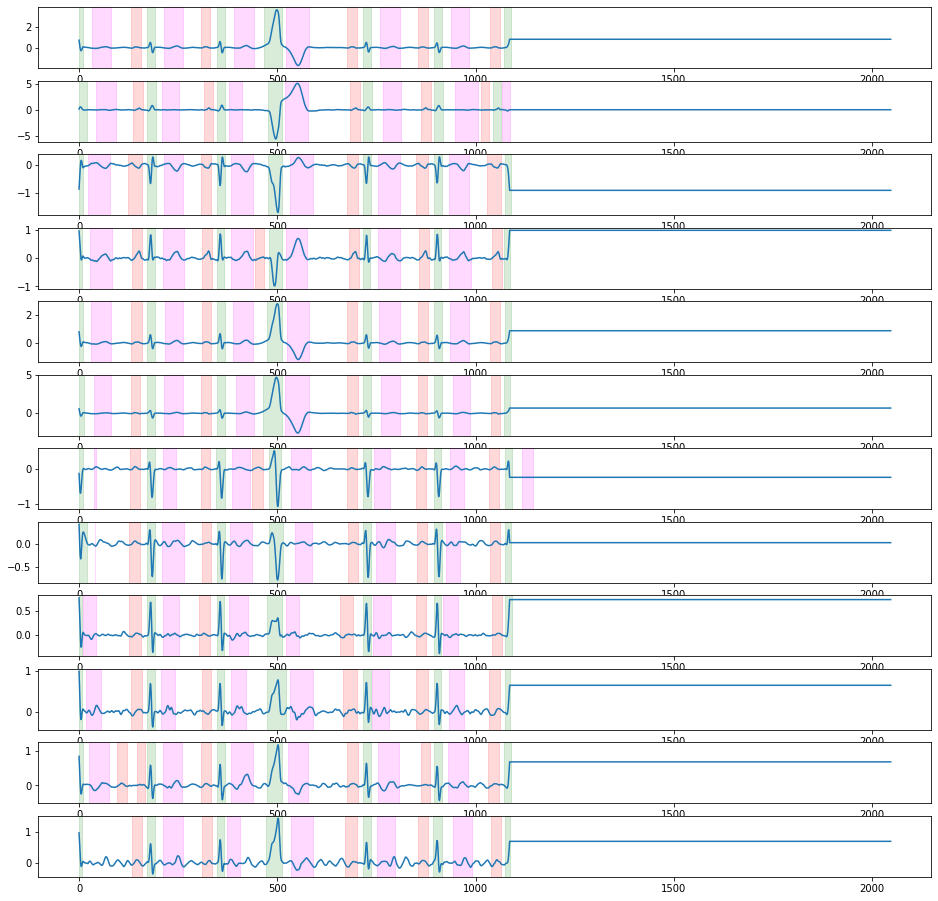

In [96]:
f,ax = plt.subplots(nrows=12,figsize=(16,16))
[sak.visualization.signal.segmentation(signal[:,i],segmentation[i,].astype(bool),fig=f,ax=ax[i]) for i in range(12)]

In [89]:
segmentation.shape

(12, 3, 2048)

In [18]:
segmentation.shape

(3, 2176)

In [15]:
signal

(2176, 12)

In [14]:
segmentation.shape

(3, 2176)

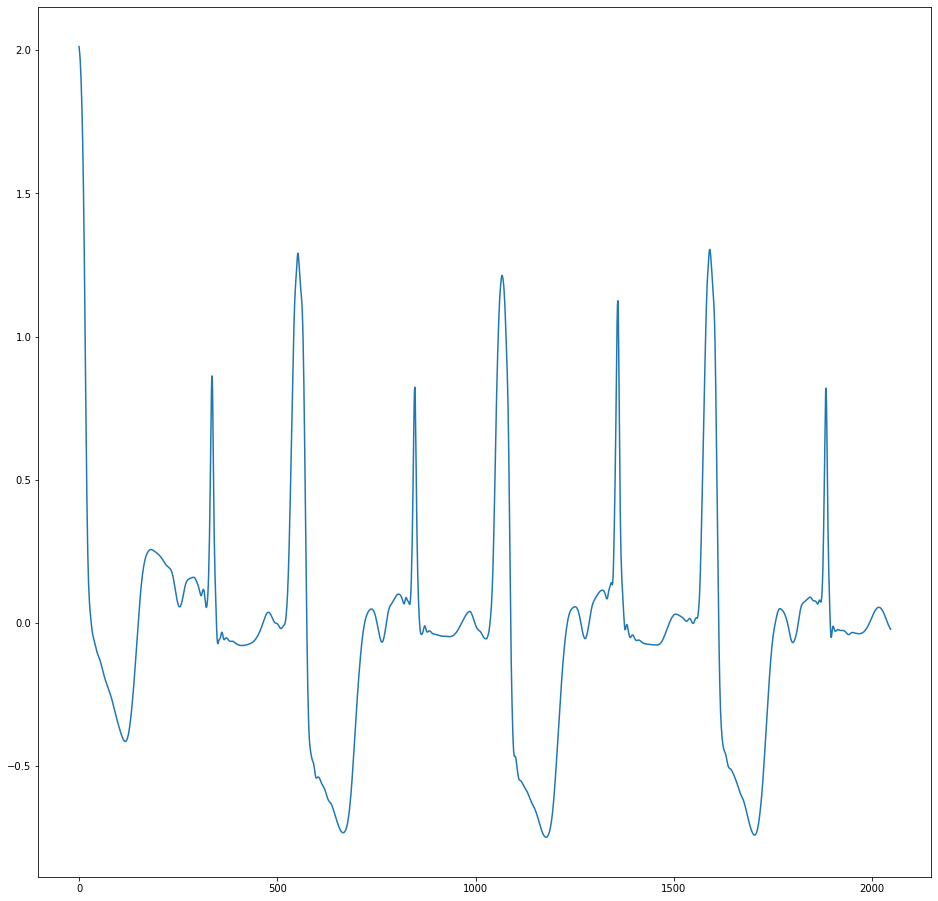

In [24]:
plt.figure(figsize=(16,16));plt.plot(signal[:2048,0])

In [ ]:
sak.visualization.

In [20]:
signal.shape

(11008, 12)

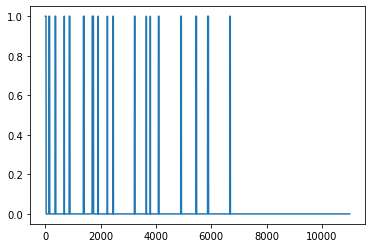

In [18]:
plt.plot(predictions[fname][2,:])

In [11]:
print(metrics_string)


# WNet5BoundLoss_20201026000000
######### P wave #########

Precision:    88.39%
Recall:       48.65%
F1 score:     62.76%

Onset Error:  -413.94 ± 173.77 ms
Offset Error: 86.75 ± 98.84 ms


######### QRS wave #########

Precision:    97.82%
Recall:       99.13%
F1 score:     98.47%

Onset Error:  -5.45 ± 90.26 ms
Offset Error: 65.64 ± 113.56 ms


######### T wave #########

Precision:    56.79%
Recall:       66.4%
F1 score:     61.22%

Onset Error:  -175.77 ± 324.69 ms
Offset Error: 484.09 ± 485.56 ms


---
